# 目的

* tensorboardで遊ぶnotebookです。torchからtensorboardを呼び出してwineデータで遊ぶ流れになっています。
* 数多くあるtensorboardの機能のうち個人的によく使いそうなやつだけピックアップしました。
* tensorflowやkerasと一緒に使うやり方についてはググってください。
* jupyterlabと一緒に使うやり方についてもググってください。（うまくいったら教えていただけますと幸いです。m(_ _)m）

* tensorboardの起動コマンド

```
tensorboard --logdir {対象のパス}
```

* 実行確認環境

    torch==1.3.1
    
    tensorboard==1.14.0
    
    tensorflow==1.14.0

In [1]:
from fastprogress import progress_bar
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="./log/test1/")#<-----------------------------writerの定義

/home/yosuke-kurosu/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yosuke-kurosu/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yosuke-kurosu/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yosuke-kurosu/.local/lib/python3.6/site-pac

# 特徴量可視化

In [3]:
wine = load_wine()

In [4]:
writer.add_embedding(mat=wine.data, metadata=wine.target) #<-----------------------------特徴量情報の追加

# ネットワークおよび学習の可視化

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(13, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
model = Net()

In [8]:
scl = StandardScaler()
X_scl = scl.fit_transform(wine.data)
X_train, X_test, y_train, y_test = train_test_split(X_scl, wine.target, test_size=0.2, stratify=wine.target, random_state=0)
train_dataset = TensorDataset(torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(y_train.astype(np.int32)).long())
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int32)).long())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=32, 
                                               shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=1, 
                                               shuffle=True)

In [9]:
num_epochs = 200
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
                            model.parameters(),
                            lr=learning_rate,
                            )

In [10]:
for epoch in progress_bar(range(num_epochs)):
    train_loss_list = []
    valid_loss_list = []
    """
    train
    """
    model.train()
    for data in train_loader:
        if epoch == 0:
            writer.add_graph(model, data[0]) #<-----------------------------ネットワーク情報の追加
        optimizer.zero_grad()
        loss = criterion(model(data[0]), data[1])
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
        
    """
    validate 
    """   
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            loss = criterion(model(data[0]), data[1])
            valid_loss_list.append(loss.item())        
    train_loss = np.average(train_loss_list)
    valid_loss = np.average(valid_loss_list)
    print(f"trainloss:{train_loss}")
    print(f"validloss:{valid_loss}")
    writer.add_scalar("loss/train", train_loss, epoch)#<-----------------------------学習情報の追加
    writer.add_scalar("loss/valid", valid_loss, epoch)#<-----------------------------学習情報の追加   

trainloss:1.1033690214157104
validloss:1.1050540192259684
trainloss:1.1018374681472778
validloss:1.104992417825593
trainloss:1.1068699359893799
validloss:1.1049300167295668
trainloss:1.1080261707305907
validloss:1.1048655874199338
trainloss:1.1012614488601684
validloss:1.1048049678405125
trainloss:1.1034130334854126
validloss:1.1047437356577978
trainloss:1.1073378324508667
validloss:1.1046786904335022
trainloss:1.1087119102478027
validloss:1.1046163853671815
trainloss:1.1046506404876708
validloss:1.1045561449395285
trainloss:1.0977431058883667
validloss:1.1044961147838168
trainloss:1.1018555164337158
validloss:1.1044337269332674
trainloss:1.1077346801757812
validloss:1.1043679300281737
trainloss:1.1019015073776246
validloss:1.1043053087260988
trainloss:1.0928290247917176
validloss:1.1042475915617413
trainloss:1.1007206678390502
validloss:1.1041893627908494
trainloss:1.1035454988479614
validloss:1.1041293491919835
trainloss:1.1071998834609986
validloss:1.1040683835744858
trainloss:1.105

In [11]:
writer.close() #<-----------------------------writerを閉じる

# 2つのモデルを比較したい
- 上層の階層からtensorboardを起動すればOK

In [12]:
writer = SummaryWriter(log_dir="./log/test2/")

In [13]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(13, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc4 = nn.Linear(30, 3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [14]:
model2 = Net2()

In [15]:
num_epochs = 200
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
                            model2.parameters(),
                            lr=learning_rate,
                            )

In [16]:
for epoch in progress_bar(range(num_epochs)):
    train_loss_list = []
    valid_loss_list = []
    """
    train
    """
    model2.train()
    for data in train_loader:
        if epoch == 0:
            writer.add_graph(model2, data[0]) #<-----------------------------ネットワーク情報の追加
        optimizer.zero_grad()
        loss = criterion(model2(data[0]), data[1])
        loss.backward()
        optimizer.step()
        train_loss_list.append(loss.item())
        
    """
    validate 
    """   
    model2.eval()
    with torch.no_grad():
        for data in test_loader:
            loss = criterion(model2(data[0]), data[1])
            valid_loss_list.append(loss.item())        
    train_loss = np.average(train_loss_list)
    valid_loss = np.average(valid_loss_list)
    print(f"trainloss:{train_loss}")
    print(f"validloss:{valid_loss}")
    writer.add_scalar("loss/train", train_loss, epoch)#<-----------------------------学習情報の追加
    writer.add_scalar("loss/valid", valid_loss, epoch)#<-----------------------------学習情報の追加   

trainloss:1.0951523065567017
validloss:1.0945901572704315
trainloss:1.0957547664642333
validloss:1.0945741186539333
trainloss:1.0971065998077392
validloss:1.094557672739029
trainloss:1.0954941272735597
validloss:1.0945420927471585
trainloss:1.094667649269104
validloss:1.0945254448387358
trainloss:1.0951356172561646
validloss:1.0945096893443003
trainloss:1.0953325986862184
validloss:1.0944932053486507
trainloss:1.096268630027771
validloss:1.094476232926051
trainloss:1.0935488224029541
validloss:1.0944591727521684
trainloss:1.0976393222808838
validloss:1.094441960255305
trainloss:1.0949442386627197
validloss:1.0944257974624634
trainloss:1.094804549217224
validloss:1.0944096595048904
trainloss:1.0944398641586304
validloss:1.0943924486637115
trainloss:1.0963120460510254
validloss:1.0943759895033307
trainloss:1.0959446907043457
validloss:1.0943591843048732
trainloss:1.093791913986206
validloss:1.0943418261077669
trainloss:1.0948365688323975
validloss:1.0943251897891362
trainloss:1.095307397

In [17]:
writer.close() #<-----------------------------writerを閉じる

# 画像データを渡す

## 画像データを一枚渡す

In [18]:
writer = SummaryWriter(log_dir="./log/image/")

In [19]:
import librosa
import matplotlib.pyplot as plt

In [20]:
N_FFT = 512
HOP_LEN = int(N_FFT/2)

In [21]:
def makemelsp(y):
    spec = np.abs(librosa.core.stft(y,n_fft=N_FFT,hop_length=HOP_LEN))**2
    log_stft = librosa.power_to_db(spec)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

In [22]:
# 適当なメルスペクトログラムの作成
filename = librosa.util.example_audio_file()
y, sr = librosa.load(filename, sr=None)
melsp = makemelsp(y[:44100])
melsp = melsp.reshape(1, *melsp.shape)

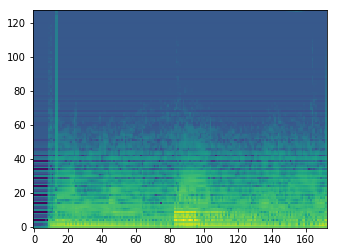

In [23]:
plt.imshow(melsp.squeeze(), origin="lower")

In [25]:
melsp.shape

(1, 128, 173)

In [26]:
writer.add_image("sample/1", melsp, 0) #<-----------------------------画像データの追加(C, H, W)

## 画像データを複数渡す

In [27]:
melsp2 = makemelsp(y[44100:44100*2])

In [28]:
melsp = melsp.reshape(1, *melsp.shape)
melsp2 = melsp2[np.newaxis, np.newaxis, :, :]

In [29]:
melsps = np.concatenate((melsp, melsp2))

In [30]:
melsps.shape

(2, 1, 128, 173)

In [31]:
writer.add_images("sample/2", melsps, 0)#<-----------------------------画像データの追加(N, C, H, W)

## カラー画像を渡したい
- matplotlibで画像を作ってfigを渡してやればいい

In [32]:
def tensors_to_fig(target):
    fig, axs = plt.subplots(1, target.shape[0], figsize=(int(target.shape[0]*4), 5))
    axs = axs.ravel()
    print(target.shape)
    for i in range(target.shape[0]):
        axs[i].imshow(target[i].squeeze(), origin="lower")
    return fig

In [33]:
writer.add_figure("sample/3", tensors_to_fig(melsps), 0)#<-----------------------------figデータの追加(figであればなんでもOK)

(2, 1, 128, 173)


In [34]:
writer.close()